## Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

### Don't have to add next code block if data is already cleaned

In [2]:
veh_cleaned_df = pd.read_csv('cleaned_vehicles.csv')
# print(veh_cleaned_df.head(5))

# Retransform data
label_encoder = LabelEncoder()
categorical_cols = ['region', 'type', 'state']
for col in categorical_cols:
    veh_cleaned_df[col] = label_encoder.fit_transform(veh_cleaned_df[col].astype(str))

veh_cleaned_df = veh_cleaned_df.dropna()

# Calculate the IQR (Interquartile Range)
Q1 = veh_cleaned_df['price'].quantile(0.25)
Q3 = veh_cleaned_df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows with prices outside the bounds
veh_cleaned_df = veh_cleaned_df[(veh_cleaned_df['price'] >= lower_bound) & (veh_cleaned_df['price'] <= upper_bound)]

# Remove rows with zero values in the 'price' column
df_no_zeros = veh_cleaned_df[veh_cleaned_df['price'] != 0]

# Print the number of rows before and after removing zeros
print(f'Number of rows before removing zeros: {len(veh_cleaned_df)}')
print(f'Number of rows after removing zeros: {len(df_no_zeros)}')

# Update your dataframe with the rows without zeros
veh_cleaned_df = df_no_zeros

# print(veh_cleaned_df.head(5))

print(veh_cleaned_df.describe())

Number of rows before removing zeros: 418694
Number of rows after removing zeros: 385799
   region  price  year  manufacturer  model  odometer  type  state
0     277   6000    18            25  11850      5415     6      3
1     105  11900    18            25  11850      5415     6      2
2     111  21000    18            25  11850      5415     6      9
3     396   1500    18            25  11850      5415     6     19
4     131   4900    18            25  11850      5415     6     27
              region          price           year  manufacturer  \
count  385799.000000  385799.000000  385799.000000  385799.00000   
mean      193.758688   17735.309068      35.617653      21.45060   
std       117.821621   12762.213935      43.766131      13.68469   
min         0.000000       1.000000       0.000000       0.00000   
25%        82.000000    6999.000000       8.000000       6.00000   
50%       197.000000   14995.000000      11.000000      23.00000   
75%       290.000000   26900.0000

### According to the error, it needs 30GB of RAM to run this lol. I might try dropping some columns but I suspect the accuracy would be really low.

In [7]:
veh_cleaned_df.drop(['region','state'], axis = 1, inplace = True)

X = veh_cleaned_df.drop('price',axis = 1)
y = veh_cleaned_df['price']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

log_res_model = LogisticRegression(random_state=42)
log_res_model.fit(X_train_pca,y_train)

# Make predictions on the test set
y_pred = log_res_model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy}')

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass problems
print(f'F1-score on Test Set: {f1}')

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

MemoryError: Unable to allocate 30.4 GiB for an array with shape (308639, 13221) and data type float64

### I tried using pipeline and split the data, but it has extremely low accuracy. 

Accuracy on Test Set: 0.015487299118714359
F1-score on Test Set: 0.004412295998676152


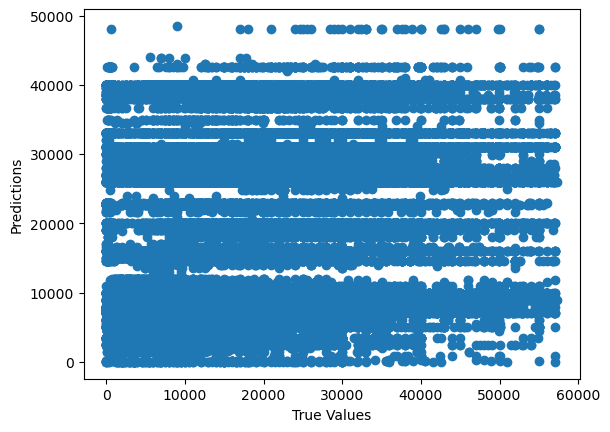

In [6]:
X = veh_cleaned_df.drop('price',axis = 1)
y = veh_cleaned_df['price']
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing steps and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize numerical features
    ('pca', PCA(n_components=7)),  # PCA for dimensionality reduction
    ('model', LogisticRegression(random_state=42,max_iter=1000))  # Logistic Regression model
])

# Use the pipeline to fit the model using partial_fit in a loop for chunked data
chunk_size = 10000
for i in range(0, len(X_train), chunk_size):
    X_chunk = X_train[i:i+chunk_size]
    y_chunk = y_train[i:i+chunk_size]
    pipeline.fit(X_chunk, y_chunk)  # Use partial_fit

# After partial_fit, you can make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy}')

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass problems
print(f'F1-score on Test Set: {f1}')

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()